In [1]:
%load_ext autoreload
%autoreload 2

## Getting started

In [2]:
# Uncomment and run the next lines if Mesa and/or svgpath2mpl are missing

#!pip install -U "mesa[all]"
#!pip install svgpath2mpl

Execute each code cell with **Shift-Enter** and watch the output.


In [3]:
import matplotlib.pylab as plt
from matplotlib import animation
from IPython.display import HTML, Image, Video
import seaborn as sns
import numpy as np
import pandas as pd
from mesa import batch_run

from model import StigmergyModel

## Visualization of one step in the simulation


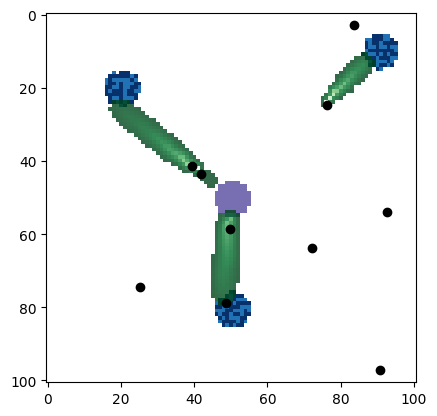

In [4]:
m1 = StigmergyModel(seed=100)

for _ in range(400):
    m1.step()

food = np.array(m1.food.copy(), dtype=np.float64)
food[food < 1] = np.nan
plt.imshow(food, cmap="Blues_r", vmax=5)

nest = np.array(m1.nest.copy(), dtype=np.float64)
nest[nest < 1] = np.nan
plt.imshow(nest, cmap="Purples_r", vmax=3, vmin=0)

pheromone = np.array(m1.pheromone.copy(), dtype=np.float64)
pheromone[pheromone < 1] = np.nan
plt.imshow(pheromone, cmap="Greens_r", alpha=0.8)


for a in list(m1.agents):
    plt.scatter(a.y, a.x, c="k")

plt.show()

## Generate gifs


In [ ]:
STEPS = 400  # how many times you call m1.step()
INTERVAL_MS = 50  # delay between frames in the live preview
SAVE_SIMULATION = "ant_sim.mp4"  # or change extension to .mp4 for MP4 output

m1 = StigmergyModel(seed=100, n_ants=50)

fig, ax = plt.subplots(figsize=(4,4))
im_food = ax.imshow(np.zeros_like(m1.food, dtype=float), cmap="Blues_r",
                     vmax=5, animated=True)
im_nest = ax.imshow(np.zeros_like(m1.nest, dtype=float), cmap="Purples_r",
                     vmax=3, vmin=0, animated=True)
im_pheromone = ax.imshow(np.zeros_like(m1.pheromone, dtype=float), cmap="Greens_r", alpha=0.8, animated=True)
scatter = ax.scatter([], [], c="k", s=5, animated=True)
ax.axis("off")  # hide axes for a cleaner look

def init():
    """Blank first frame (required by FuncAnimation)."""
    im_food.set_data(np.full_like(m1.food, np.nan, dtype=float))
    im_nest.set_data(np.full_like(m1.nest, np.nan, dtype=float))
    im_pheromone.set_data(np.full_like(m1.pheromone, np.nan, dtype=float))
    return im_food, im_nest, im_pheromone, scatter

def update(frame):
    """Called once per step; mutates `m1` and updates artists."""
    m1.step()  # advance the model

    food = m1.food.astype(float)
    food[food < 1] = np.nan
    im_food.set_data(food)

    nest = m1.nest.astype(float)
    nest[nest < 1] = np.nan
    im_nest.set_data(nest)

    pheromone = m1.pheromone.astype(float)
    pheromone[pheromone < 1] = np.nan
    im_pheromone.set_data(pheromone)

    xy = np.array([[a.y, a.x] for a in m1.agents])

    colors  = ['gold' if a.carrying else 'black' for a in m1.agents]
    scatter.set_offsets(xy)
    scatter.set_color(colors)

    return im_food, im_nest, im_pheromone, scatter

anim = animation.FuncAnimation(
    fig, update, frames=STEPS, init_func=init,
    blit=True, interval=INTERVAL_MS
);

In [ ]:
# Saving to a file (GIF or MP4)
# anim.save(SAVE_SIMULATION, writer="pillow", fps=1000//INTERVAL_MS)
# anim.save(SAVE_SIMULATION, writer="ffmpeg", fps=1000//INTERVAL_MS)

# Show the save file in Jupyter Notebook
# Image(SAVE_SIMULATION)
# Video(SAVE_SIMULATION)

# Or play animation directly in the Jupyter Notebook
HTML(anim.to_jshtml())

## Resource consumption analysis


In [7]:
import multiprocessing
n_cpu = multiprocessing.cpu_count()
print(n_cpu)

8


In [8]:
BATCH_PARAMS = {
    "n_ants": [10, 20, 30],  # try different colony sizes
    "kappa": [5.0],       # keep turning stiffness fixed for now
}

batch_results = batch_run(
    StigmergyModel,
    parameters=BATCH_PARAMS,
    iterations=40,  # replicate each parameter set 20 times
    max_steps=1000,
    number_processes=n_cpu,  # set >1 for parallel execution on multi‑core machines
    data_collection_period=1,  # collect at every step (required for MSD)
    display_progress=True,
)

batch_results = pd.DataFrame(batch_results)
batch_results.head()

  0%|          | 0/120 [00:00<?, ?it/s]

,RunId,iteration,Step,n_ants,kappa,total_pheromone,remaining_food
0,3,1,0,10,5.0,0.0,370
1,3,1,1,10,5.0,0.0,370
2,3,1,2,10,5.0,0.0,370
3,3,1,3,10,5.0,0.0,370
4,3,1,4,10,5.0,0.0,370


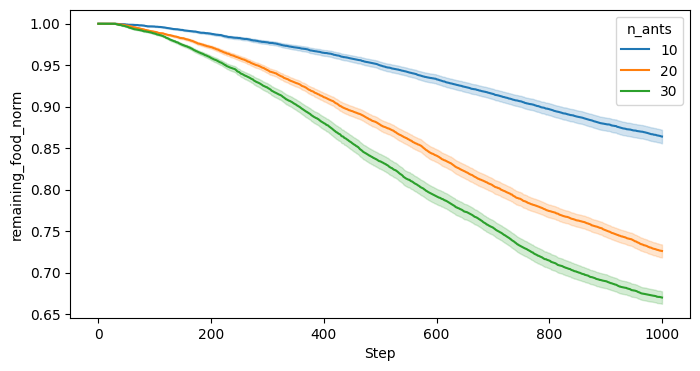

In [9]:
cols = ['n_ants', 'iteration', 'kappa'] # the grouping keys

batch_results['remaining_food_norm'] = (
        batch_results['remaining_food'] /
        batch_results.groupby(cols)['remaining_food'].transform('max')
)

g = sns.lineplot(
    data=batch_results,
    x="Step",
    y="remaining_food_norm",
    hue="n_ants",
    errorbar="se",
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plt.show()

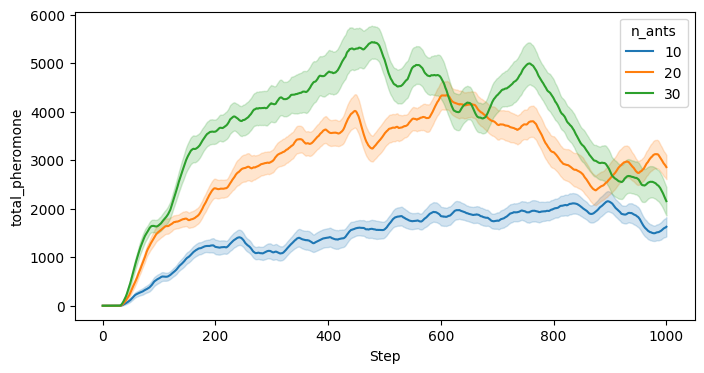

In [10]:
g = sns.lineplot(
    data=batch_results,
    x="Step",
    y="total_pheromone",
    hue="n_ants",
    errorbar="se",
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plt.show()